### Prepare Data

In [3]:
import shutil
import os
import pandas as pd

In [ ]:
df = pd.read_csv('C:/Users/tianminli/Desktop/dl/labels.csv')
path = 'for_train'

if os.path.exists(path):
    shutil.rmtree(path)

for i, (file_name, breed) in df.iterrows():
    new_path = '%s/%s' % (path, breed)
    if not os.path.exists(new_path):
        os.makedirs(new_path)
    os.symlink('../../train/%s.jpg' % file_name, '%s/%s.jpg' % (new_path, file_name))

In [5]:
df = pd.read_csv('sample_submission.csv')
path = 'for_test'
breed = '0'

if os.path.exists(path):
    shutil.rmtree(path)

for file_name in df['id']:
    new_path = '%s/%s' % (path, breed)
    if not os.path.exists(new_path):
        os.makedirs(new_path)
    os.symlink('../../test/%s.jpg' % file_name, '%s/%s.jpg' % (new_path, file_name))

### Save Features

In [18]:
import mxnet as mx
import numpy as np
import pandas as pd
import cv2
import h5py
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from mxnet import autograd
from mxnet import gluon
from mxnet import image
from mxnet import init
from mxnet import nd
from mxnet.gluon import nn
from mxnet.gluon.data import vision
from mxnet.gluon.model_zoo import vision as models

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

ctx = [mx.gpu(i) for i in range(1)]

In [ ]:
def save_features(model_name, data_train_iter, data_test_iter, ignore=False):
    if os.path.exists('features_train_%s.nd' % model_name) and ignore:
        if os.path.exists('features_test_%s.nd' % model_name):
            return
    
    model = models.get_model(model_name, pretrained=True, ctx=ctx)
    
    for prefix, data_iter in zip(['train', 'test'], [data_train_iter, data_test_iter]):
        features = []
        for data in tqdm(data_iter):
            for data_slice in gluon.utils.split_and_load(data, ctx, even_split=False):
                feature = model.features(data_slice)
                if 'squeezenet' in model_name:
                    feature = gluon.nn.GlobalAvgPool2D()(feature)
                feature = gluon.nn.Flatten()(feature)
                features.append(feature.as_in_context(mx.cpu()))
            nd.waitall()
        
        features = nd.concat(*features, dim=0)
        nd.save('features_%s_%s.nd' % (prefix, model_name), features)

In [4]:
df = pd.read_csv('C:/Users/tianminli/Desktop/dl/labels.csv')
synset = sorted(set(df['breed']))
n = len(df)

X_224 = nd.zeros((n, 3, 224, 224))
X_299 = nd.zeros((n, 3, 299, 299))
y = nd.zeros((n,))

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
for i, (file_name, breed) in tqdm(df.iterrows(), total=n):
    img = cv2.imread('train/%s.jpg' % file_name)
    img_224 = ((cv2.resize(img, (224, 224))[:,:,::-1] / 255.0 - mean) / std).transpose((2, 0, 1))
    img_299 = ((cv2.resize(img, (299, 299))[:,:,::-1] / 255.0 - mean) / std).transpose((2, 0, 1))
    
    X_224[i] = nd.array(img_224)
    X_299[i] = nd.array(img_299)
    
    y[i] = synset.index(breed)
    
    nd.waitall()

100%|████████████████████████████████████████████████████████████████████████████| 10222/10222 [02:16<00:00, 74.81it/s]


In [ ]:
df_test = pd.read_csv('sample_submission.csv')
n_test = len(df_test)
X_224_test = nd.zeros((n_test, 3, 224, 224))
X_299_test = nd.zeros((n_test, 3, 299, 299))

for i, file_name in tqdm(enumerate(df_test['id']), total=n_test):
    img = cv2.imread('test/%s.jpg' % file_name)
    img_224 = ((cv2.resize(img, (224, 224))[:,:,::-1] / 255.0 - mean) / std).transpose((2, 0, 1))
    img_299 = ((cv2.resize(img, (299, 299))[:,:,::-1] / 255.0 - mean) / std).transpose((2, 0, 1))
    
    X_299_test[i] = nd.array(img_299)    
    X_224_test[i] = nd.array(img_224)
    
    nd.waitall()

In [19]:
#uncomment lines below to save to loacl if files not existed
#nd.save('train.nd', [X_224, X_299, y])
#nd.save('labels.nd', y)
#nd.save('test.nd', [X_224_test, X_299_test])

#uncomment lines below to load from local if files already existed
#X_224, X_299, y = nd.load('train.nd')
#X_224_test, X_299_test = nd.load('test.nd')

In [22]:
batch_size = 128

data_iter_224 = gluon.data.DataLoader(gluon.data.ArrayDataset(X_224), batch_size=batch_size)
data_iter_299 = gluon.data.DataLoader(gluon.data.ArrayDataset(X_299), batch_size=batch_size)

data_test_iter_224 = gluon.data.DataLoader(gluon.data.ArrayDataset(X_224_test), 
                                           batch_size=batch_size)
data_test_iter_299 = gluon.data.DataLoader(gluon.data.ArrayDataset(X_299_test), 
                                           batch_size=batch_size)

In [26]:
save_features('inceptionv3', data_iter_299, data_test_iter_299)

1
2
3


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [01:26<00:00,  4.68s/it]


In [12]:
save_features('resnet152_v1', data_iter_224, data_test_iter_224)

1
2
3


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [01:10<00:00,  2.25s/it]


### Train New Model

In [10]:
def load_models_data(model_names, batch_size=128, train_size=0.8):
    features = [nd.load('features_train_%s.nd' % model_name)[0] for model_name in model_names]
    features = nd.concat(*features, dim=1)
    labels = nd.load('labels.nd')[0]
    
    n_train = int(features.shape[0]*train_size)
    
    X_train = features[:n_train]
    y_train = labels[:n_train]

    X_val = features[n_train:]
    y_val = labels[n_train:]

    dataset_train = gluon.data.ArrayDataset(X_train, y_train)
    dataset_val = gluon.data.ArrayDataset(X_val, y_val)

    data_iter_train = gluon.data.DataLoader(dataset_train, batch_size, shuffle=True)
    data_iter_val = gluon.data.DataLoader(dataset_val, batch_size)
    
    return data_iter_train, data_iter_val

In [11]:
def build_model():
    model = nn.Sequential()
    with model.name_scope():
        model.add(nn.Dense(256, activation='relu'))
        model.add(nn.Dropout(0.5))
        model.add(nn.Dense(120))

    model.initialize(ctx=ctx)
    return model

In [ ]:
def accuracy(output, labels):
    return nd.mean(nd.argmax(output, axis=1) == labels).asscalar()

In [20]:
def evaluate(model, data_iter):
    loss, acc, n = 0., 0., 0.
    steps = len(data_iter)
    for data, label in data_iter:
        data, label = data.as_in_context(ctx), label.as_in_context(ctx)
        output = model(data)
        acc += accuracy(output, label)
        loss += nd.mean(softmax_cross_entropy(output, label)).asscalar()
    return loss/steps, acc/steps

In [37]:
ctx = mx.gpu() 
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

#existing best performing models to transfer learning from
existing_models = ['inceptionv3', 'resnet152_v1']
data_iter_train, data_iter_val = load_models_data(existing_models, batch_size=batch_size)

epochs = 100
batch_size = 128
model = build_model()
lr_sch = mx.lr_scheduler.FactorScheduler(step=400, factor=0.9)
trainer = gluon.Trainer(model.collect_params(), 'adam', 
                        {'learning_rate': 1e-4, 'wd': 1e-5, 'lr_scheduler': lr_sch})

train_accuracy = []
validation_accuracy = []
train_loss = []
validation_loss = []

for epoch in range(epochs):
    total_loss = 0.
    total_accuracy = 0.
    steps = len(data_iter_train)
    for data, label in data_iter_train:
        data, label = data.as_in_context(ctx), label.as_in_context(ctx)

        with autograd.record():
            output = model(data)
            loss = softmax_cross_entropy(output, label)

        loss.backward()
        trainer.step(batch_size)

        total_loss += nd.mean(loss).asscalar()
        total_accuracy += accuracy(output, label)

    val_loss, val_acc = evaluate(model, data_iter_val)
    
    train_accuracy.append(total_accuracy/steps)
    validation_accuracy.append(val_acc)
    train_loss.append(total_loss/steps)
    validation_loss.append(val_loss)
    
    print("Epoch %d: loss: %.4f, acc: %.2f%%, val_loss %.4f, val_acc %.2f%%" % (
        epoch+1, total_loss/steps, total_accuracy/steps*100, val_loss, val_acc*100))

Epoch 1: loss: 4.5091, acc: 6.38%, val_loss 3.8941, val_acc 33.40%
Epoch 2: loss: 3.4633, acc: 29.23%, val_loss 2.5818, val_acc 70.42%
Epoch 3: loss: 2.3369, acc: 53.32%, val_loss 1.5436, val_acc 80.93%
Epoch 4: loss: 1.6167, acc: 66.69%, val_loss 1.0045, val_acc 86.40%
Epoch 5: loss: 1.2128, acc: 73.29%, val_loss 0.7428, val_acc 87.14%
Epoch 6: loss: 0.9900, acc: 77.37%, val_loss 0.6042, val_acc 88.60%
Epoch 7: loss: 0.8425, acc: 79.46%, val_loss 0.5217, val_acc 88.95%
Epoch 8: loss: 0.7413, acc: 81.64%, val_loss 0.4690, val_acc 89.29%
Epoch 9: loss: 0.6628, acc: 82.88%, val_loss 0.4324, val_acc 89.73%
Epoch 10: loss: 0.6091, acc: 84.38%, val_loss 0.4034, val_acc 90.12%
Epoch 11: loss: 0.5785, acc: 85.06%, val_loss 0.3808, val_acc 90.32%
Epoch 12: loss: 0.5374, acc: 85.47%, val_loss 0.3652, val_acc 90.61%
Epoch 13: loss: 0.4987, acc: 86.35%, val_loss 0.3505, val_acc 90.27%
Epoch 14: loss: 0.4808, acc: 86.83%, val_loss 0.3399, val_acc 90.66%
Epoch 15: loss: 0.4734, acc: 87.14%, val_los

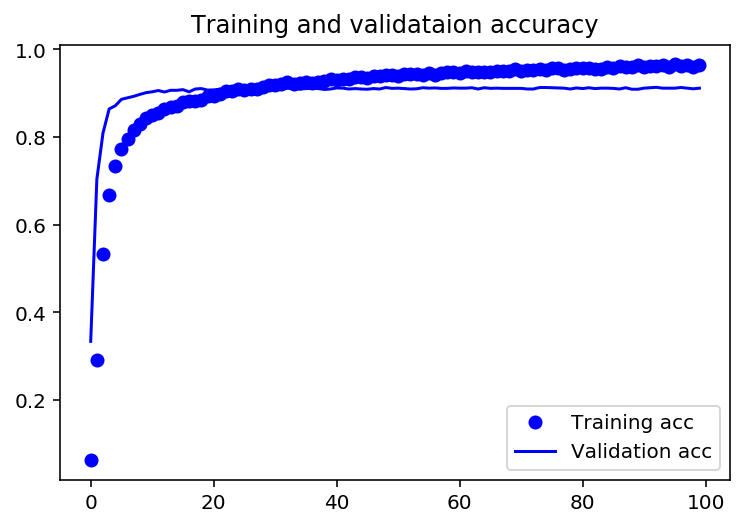

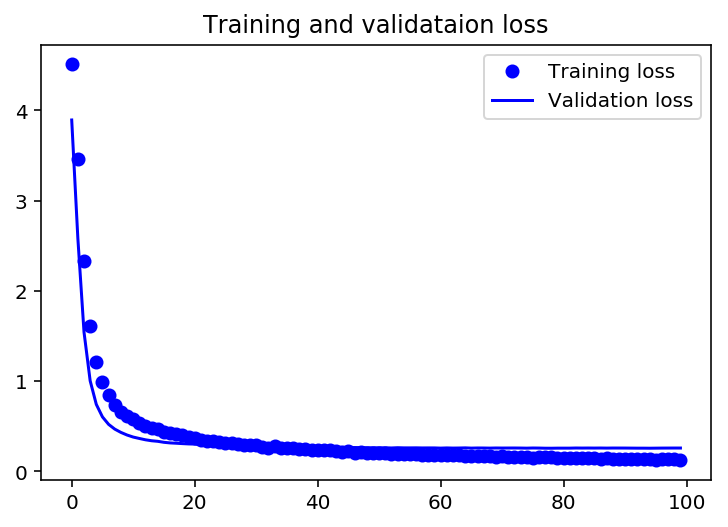

In [41]:
epochs = range(len(train_accuracy))
plt.plot(epochs, train_accuracy, 'bo', label = 'Training acc')
plt.plot(epochs, validation_accuracy, 'b', label = 'Validation acc')
plt.title('Training and validataion accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_los, 'bo', label = 'Training loss')
plt.plot(epochs, validation_loss, 'b', label = 'Validation loss')
plt.title('Training and validataion loss')
plt.legend()

plt.show()